<a href="https://colab.research.google.com/github/andrejfg/Emo-es-CNN/blob/main/Emo%C3%A7%C3%B5es_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de reconhecimento de emoções

O modelo foi treinado com a base de imagens FER-2013 do Kaggle (https://www.kaggle.com/msambare/fer2013).

Esta base de imagens é composta por imagens preto e branco de tamanho (48x48) pixels. Já é separada entre treino e teste e possui 6+1 emoções sendo elas: 
* Raiva
* Nojo
* Medo 
* Alegria 
* Tristeza 
* Surpresa 
* Neutro

O modelo foi montado a partir de uma variação da arquitetura VGG-16, apenas com adições de camadas de *Batch Normalization* e *Dropout* para afim de evitar *overfitting* cedo durante o treino.


# Carregamento da base de dados

## Importação e configuração do kaggle dentro do ambiente 

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! rm -rf ~/.kaggle
! mkdir ~/.kaggle 
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Carregamento da base de dados FER-2013

In [2]:
! kaggle datasets download -d msambare/fer2013

 90% 54.0M/60.3M [00:00<00:00, 127MB/s]
100% 60.3M/60.3M [00:00<00:00, 136MB/s]


Extrai o arquivo zip do FER-2013

In [3]:
from zipfile import ZipFile
with ZipFile("/content/fer2013.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/fer2013/")

# Importações

In [4]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# Carregar as imagens de cada emoção individualmente

0.   Raiva
1.   Nojo
2.   Medo
3.   Alegria
4.   Tristeza
5.   Surpresa
6.   Neutro






In [5]:
emocoes =[
           'Raiva', 
           'Nojo',
           'Medo', 
           'Alegria', 
           'Tristeza', 
           'Surpresa', 
           'Neutro'
          ]

Captura o nome de todos os nomes das imagens

In [6]:
filenames_train = glob.glob('/content/fer2013/train/*/*.jpg', recursive=True)
filenames_test = glob.glob('/content/fer2013/test/*/*.jpg', recursive=True)
print("Número de imagens de treino: ",len(filenames_train))
print("Número de imagens de teste: ",len(filenames_test))

Número de imagens de treino:  28709
Número de imagens de teste:  7178


## Carrega base de imagens

Converte o caminho da imagem para a emoção referente

In [7]:
def rotularizador_fer(nome_do_arquivo):
  rotulo = nome_do_arquivo.split("/")[-2]
  if(rotulo == 'angry'):
    return 0;
  elif(rotulo == 'disgust'):
    return 1;
  elif(rotulo ==  'fear'):
    return 2;
  elif(rotulo == 'happy'):
    return 3;
  elif(rotulo == 'sad'):
    return 4;
  elif(rotulo == 'surprise'):
    return 5;
  elif(rotulo == 'neutral'):
    return 6;

Carrega imagem e rotula de acordo com a emoção

In [8]:
def carrega_imagens(nome_dos_arquivos):
  imagens = []
  rotulos = []
  for nome in nome_dos_arquivos:
    rotulos.append(rotularizador_fer(nome))
    imagem_tmp = load_img(nome, color_mode= 'grayscale')
    imagem_tmp = img_to_array(imagem_tmp)
    imagens.append(imagem_tmp)
  imagens = np.array(imagens)/255
  rotulos = np.array(rotulos)
  return imagens, rotulos

In [101]:
x_train, y_train = carrega_imagens(filenames_train)
x_test, y_test = carrega_imagens(filenames_test)

Exemplo de imagem do banco de dados FER-2013 com rótulo

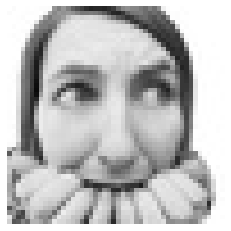

Emoção: Medo


In [102]:
plt.axis(False)
plt.imshow(x_train[15000].reshape(48,48), cmap='gray', vmin=0, vmax=1)
plt.show()
print("Emoção:", emocoes[y_train[15000]])

# Preprocessamento das bases de dados

Formato de cada imagem 48x48 pixels

In [11]:
input_shape = x_train[0].shape
input_shape

(48, 48, 1)

Parâmetros de *Data Augmentation*

*   Zoom de até 20%
*   Espelho horizontal
*   Translação horizontal
*   Translação vertical
*   Rotação de até 90 graus
*   Variação de brilho de 20% até 80%



In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rotation_range=90,
    brightness_range=(0.2,0.8),
  )
datagen.fit(x_train)

 Preprocessamento dos rótulos de emoções para o modelo

In [14]:
from tensorflow.keras.utils import to_categorical

In [15]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
print("Formato dos rótulos de treino: ",y_train.shape)
print("Formato dos rótulos de teste: ",y_test.shape)



Formato dos rótulos de treino:  (28709, 7)
Formato dos rótulos de teste:  (7178, 7)


# Cria a rede neural e cria as camadas da rede

Importação das camadas e modelos do Keras

In [16]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense , Activation , Dropout ,Flatten, BatchNormalization

### Modelo Escolhido
O modelo escolhido é inspirado no VGG-16 tendo apenas algumas adições de camadas Batch Normalization e Dropout

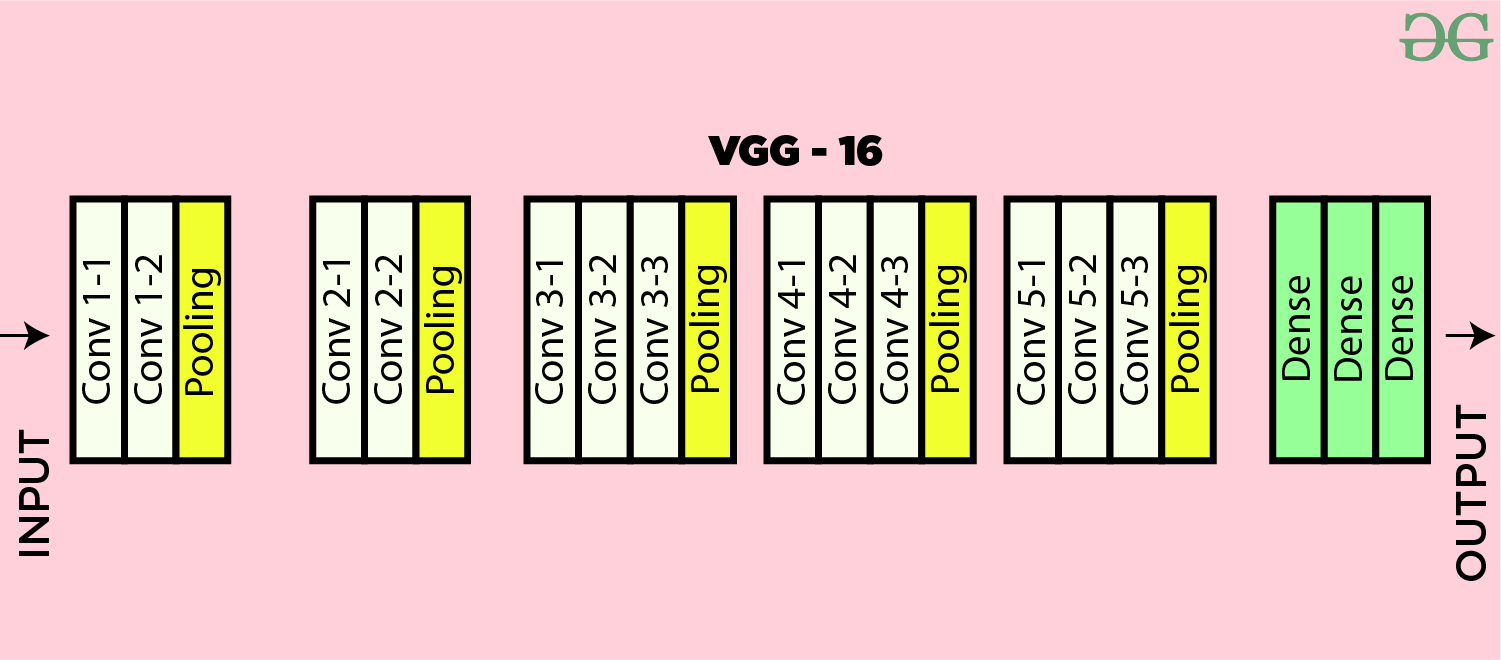

In [17]:
def carrega_VGG16(shape, verbose = 0):
  model = Sequential()

  #Primeira Etapa
  model.add( Conv2D(40, kernel_size=(3,3), activation='relu', padding='same', input_shape=shape))
  model.add(BatchNormalization())
  model.add(Conv2D(40, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  #Segunda Etapa
  model.add(Conv2D(80, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(80, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  #Terceira Etapa
  model.add( Conv2D(160, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(160, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(160, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  #Quarta Etapa
  model.add( Conv2D(320, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(320, kernel_size=(3,3), activation='relu', padding='same')) 
  model.add(BatchNormalization())
  model.add(Conv2D(320, kernel_size=(3,3), activation='relu', padding='same')) 
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  #Quinta Etapa
  model.add(Conv2D(640, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(640, kernel_size=(3,3), activation='relu', padding='same')) 
  model.add(BatchNormalization())
  model.add(Conv2D(640, kernel_size=(3,3), activation='relu', padding='same')) 
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  #Camadas densas
  model.add(Flatten())
  model.add(Dense(1000))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(500))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(7,activation='softmax'))

  model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'] 
            )

  if (verbose == 1):
    model.summary()
  
  return model

# Treina a rede neural com a base de treino

### Tolerância de melhora de até 5 épocas para acurácia de treino

In [18]:
from keras.callbacks import EarlyStopping

In [19]:
earlystoping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    verbose = 1
)

In [20]:
model = carrega_VGG16(input_shape, verbose = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 40)        400       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 40)       160       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 40)        14440     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 40)       160       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 40)       0         
 )                                                               
                                                        

## Configuração de treinamento do modelo

In [21]:
#data_augmentation = True
data_augmentation = False

In [22]:
if data_augmentation:
  history = model.fit(
    datagen.flow(x_train, y_train),
    validation_data=(x_test,y_test),
    steps_per_epoch=len(x_train) / 32,
    epochs=500, 
    callbacks=[earlystoping]
)
else:
  history = model.fit(
    x_train, y_train, 
    epochs=500, 
    validation_data=(x_test, y_test), 
    callbacks=[earlystoping]
  )

Epoch 1/500
898/898 [==============================] - 88s 83ms/step - loss: 1.9298 - accuracy: 0.2652 - val_loss: 2.9019 - val_accuracy: 0.3165
Epoch 2/500
898/898 [==============================] - 73s 81ms/step - loss: 1.5558 - accuracy: 0.4014 - val_loss: 1.5433 - val_accuracy: 0.4394
Epoch 3/500
898/898 [==============================] - 72s 81ms/step - loss: 1.3874 - accuracy: 0.4670 - val_loss: 1.3539 - val_accuracy: 0.4826
Epoch 4/500
898/898 [==============================] - 72s 80ms/step - loss: 1.2859 - accuracy: 0.5117 - val_loss: 1.2452 - val_accuracy: 0.5215
Epoch 5/500
898/898 [==============================] - 72s 80ms/step - loss: 1.2142 - accuracy: 0.5406 - val_loss: 1.3344 - val_accuracy: 0.4911
Epoch 6/500
898/898 [==============================] - 72s 80ms/step - loss: 1.1563 - accuracy: 0.5660 - val_loss: 1.2370 - val_accuracy: 0.5359
Epoch 7/500
898/898 [==============================] - 72s 80ms/step - loss: 1.0972 - accuracy: 0.5936 - val_loss: 1.1833 - val_ac

Salva modelo

In [23]:
model.save("/content/emotions_model")

INFO:tensorflow:Assets written to: /content/emotions_model/assets


# Avaliação dos modelos

Número de épocas:  26
Maior acurácia:  63.29 %


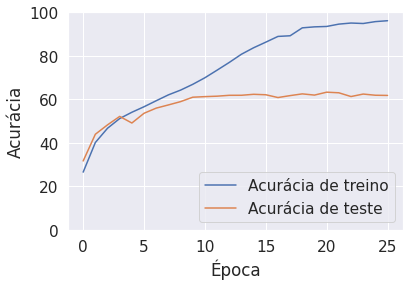

In [39]:
plt.plot(np.array(history.history['accuracy'])*100, label = 'Acurácia de treino')
plt.plot(np.array(history.history['val_accuracy'])*100, label = 'Acurácia de teste')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.ylim([0, 100])
plt.legend(loc='lower right')
print("Número de épocas: ", len(history.history['val_accuracy']))
print("Maior acurácia: ", round(max(history.history['val_accuracy'])*100,2), "%")

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [26]:
def plot_confusion_matrix(data, labels):

    sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Matriz de Confusão (%)")
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data*100, annot=True,cmap="Blues", cbar_kws={'label': 'Acurácia (%)'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="Verdadeira", xlabel="Predição")

    #plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [27]:
y_test_tmp = []
for classificacao in y_test:
  y_test_tmp.append(np.argmax(classificacao))

In [28]:
y_predicao = model.predict(x_test)

In [29]:
y_predicao_tmp = []
for classificacao in y_predicao:
  y_predicao_tmp.append(np.argmax(classificacao))

In [30]:
cf_matrix = confusion_matrix(y_test_tmp, y_predicao_tmp) 

In [31]:
max_cf_matrix = list()
for row in cf_matrix.T:
  max_cf_matrix.append(sum(row))

## Matriz de confusão

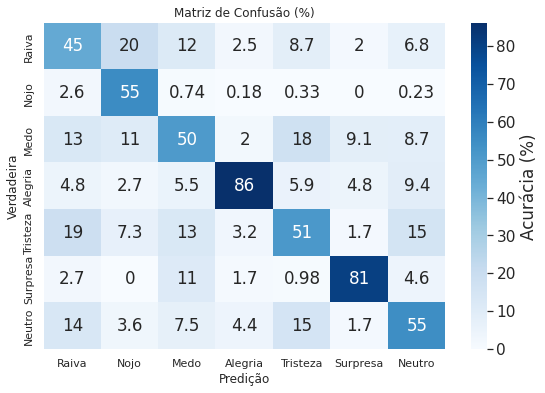

In [32]:
plot_confusion_matrix(cf_matrix/max_cf_matrix, emocoes)

# Teste com imagem da internet

In [65]:
from skimage import io
import cv2
from google.colab.patches import cv2_imshow

In [66]:
def preprocessa_imagem(imagem, modelo):
  imagem = imagem.astype(np.float64)/255
  imagem = np.expand_dims(imagem, axis = 0)
  probabilidades = modelo.predict(imagem)
  probabilidades = probabilidades[0]
  classificacao = np.argmax(probabilidades)
  certeza = round(probabilidades[np.argmax(probabilidades)]*100, ndigits= 2)

  return classificacao, certeza, probabilidades

In [96]:
image = io.imread("https://c.pxhere.com/photos/13/eb/girl_nature_spring_sun_freedom_happy_cute_joy-1038595.jpg!d")
face_recognition = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
face = face_recognition.detectMultiScale(gray, 1.3)

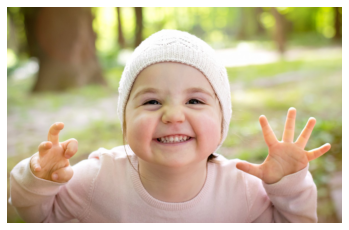

In [97]:
plt.axis(False)
plt.imshow(image)
plt.show()

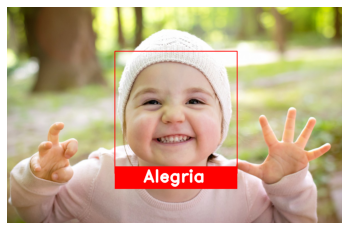

In [99]:
for (x, y, w, h) in face:
  img_predict = cv2.resize(gray[y+25:y+h+25, x-25:x+w+25],(48,48))
  resultado = preprocessa_imagem(img_predict,model)
  image_tagged = cv2.rectangle(image, (x-25,y-25),(x+w+25,y+h+25), (255, 0, 0), 2)
  image_tagged = cv2.rectangle(image_tagged,(x-25,y+h),(x+w+25,y+h+80), (255, 0, 0), cv2.FILLED)
  image_tagged = cv2.putText(image_tagged,emocoes[resultado[0]], (x+77,y+h+55), cv2.FONT_HERSHEY_DUPLEX, 2.0, (255, 255, 255), 5)
plt.axis(False)
plt.imshow(image_tagged)
plt.show()